# CUPED, or how to increase the power of AB tests 

*How to use historical data to tell noise and signal apart*

The data generating process for individual $i$ at time $t$ is the following:

$$
Y_{it} = \alpha + \beta t + \gamma D_i + \delta t D_i + \varepsilon_i + u_{it}
$$

where

- $\alpha = 5$
- $\beta = 0$
- $\gamma = 1$
- $\delta = 2$
- $D \sim Bern(0.5)$
- $\varepsilon \sim N(0,1)$
- $u \sim N(0,1)$

So that the true treatment effect is $\delta = 1$.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_cuped

In [3]:
df = dgp_cuped().generate_data()
df.head()

,i,d,y0,y1,x0,x1
0,1,0,5.315635,6.359304,7.096171,11.373674
1,2,1,2.977799,5.751485,3.598911,9.191610
2,3,0,4.693796,7.025253,5.599818,12.675708
3,4,0,5.827975,6.540667,9.974215,9.025466
4,5,0,5.230095,6.910165,7.590962,8.609321


## Difference in Means

In randomized experiments or A/B tests, randomization allows us to estimate the average treatment effect using a simple difference in means. 

We can obtain the same estimate by regressing the post-treatment outcome $y_1$ on the treatment indicator $d$.

In [4]:
smf.ols('y1 ~ d', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.2995,0.211,29.904,0.000,5.881,6.718
d,1.7914,0.301,5.953,0.000,1.194,2.389


This estimator is unbiased, i.e. it delivers the correct value, in expectation. 

Can we do **better**, using the pre-treatment information?

## Stratification

## CUPED

The CUPED (Controlled-Experiment using Pre-Experiment Data) estimator was first introduced by [Deng, Xu, Kohavi, Walker (2013)](https://dl.acm.org/doi/abs/10.1145/2433396.2433413) and has been widely used in companies such as [Netflix](https://www.kdd.org/kdd2016/papers/files/adp0945-xieA.pdf), [Booking](https://booking.ai/995d186fff1d), [Meta](https://research.facebook.com/blog/2020/10/increasing-the-sensitivity-of-a-b-tests-by-utilizing-the-variance-estimates-of-experimental-units/), [TripAdvisor](https://www.tripadvisor.com/engineering/reducing-a-b-test-measurement-variance-by-30/), and many other.

The **idea** of CUPED is the following. Suppose you have access to another random variable $X$ which is **not affected** by the treatment and has known expectation $\mathbb E[X]$. Then define

$$
\hat Y_{cuped,1} = \bar Y_1 - \theta \bar X + \theta \mathbb E [X]
$$

where $\theta$ is a scalar. This estimator is an **unbiased** estimator for $\mathbb E[Y]$ since in expectation the two last terms cancel out. However, the variance of $\hat Y_{cuped,1}$ is 

$$
\begin{aligned}
\text{Var} \left( \hat Y_{cuped,1} \right) &= \text{Var} \left( \bar Y_1 - \theta \bar X + \theta \mathbb E [X] \right) = \newline
&= \text{Var} \left( Y_1 - \theta X \right) / n = \newline
&= \Big( \text{Var} (Y_1) + \theta^2 \text{Var} (X) - 2 \theta \text{Cov} (X,Y) \Big) / n
\end{aligned}
$$

Note that the variance of $\hat Y_{cuped,1}$ is minimized for 

$$
\theta^* = \frac{\text{Cov} (X,Y)}{\text{Var} (X)} 
$$

Which is the **OLS** estimator of a linear regression of $Y$ on $X$. Substituting $\theta^*$ into the formula of the variance of $\hat Y_{cuped,1}$ we obtain

$$
\text{Var} \left( \hat Y_{cuped,1} \right) = \text{Var} (\bar Y) (1 - \rho^2)
$$

where $\rho$ is the **correlation** between $Y$ and $X$. Therefore, the higher the correlation between $Y$ and $X$, the higher the variance reduction of CUPED.

We can then **estimate the treatment effect** using the difference between control and treatment group

$$
\begin{aligned}
\Delta_{CUPED} &= \hat Y_{cuped,1}(D=1) - \hat Y_{cuped,1}(D=0) = \\
&= \big( \bar Y_1 - \theta \bar X + \theta \mathbb E [X] \ \big| \ D = 1 \big) - \big( \bar Y_1 - \theta \bar X + \theta \mathbb E [X] \ \big| \ D = 0 \big) = \\
&= \big( \bar Y_1 - \theta \bar X \ \big| \ D = 1 \big) - \big( \bar Y_1 - \theta \bar X \ \big| \ D = 0 \big)
\end{aligned}
$$

Note that $\mathbb E[X]$ cancels out when taking the difference. Therefore, it is sufficient to compute 

$$
\hat Y_{cuped,1}' = \bar Y_1 - \theta \bar X
$$

This is not an unbiased estimator of $\mathbb E[Y]$ but still delivers an unbiased estimator of the average treatment effect.

What is the **optimal choice** for the control variable $X$?

We know that $X$ should have the following properties:

- not affected by the treatment
- as correlated with $Y_1$ as possible

The authors of the paper suggest using the pre-treatment outcome $Y_{0}$ since it gives the most reduction in variance in practice. 

Therefore, **in practice**, we can compute the CUPED estimate of the average treatment effect as follows:

1. Regress $Y_1$ on $Y_0$ and estimate $\hat \theta$
2. Compute $\hat Y_{cuped,1} = \bar Y_1 - \hat \theta \bar Y_0$
3. Compute the difference of $\hat Y_{cuped,1}$ between treatment and control group

Equivalently, we can compute $\hat Y_{cuped,1}$ at the individual level and then regress it on the treatment dummy variable $D$.

In [5]:
theta = smf.ols('y1 ~ y0', data=df).fit().params[1]
theta

1.1458111091416718

In [6]:
df['y1_cuped'] = df['y1'] - theta * df['y0']

In [7]:
smf.ols('y1_cuped ~ d', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4008,0.143,2.810,0.006,0.118,0.684
d,1.9415,0.204,9.529,0.000,1.537,2.346


The standard error is 33% smaller!

### No Pre-treatment Outcome

We could use CUPED also without $Y_0$, we just need another variable that is correlated with $Y$.

In [8]:
theta_x = smf.ols('y1 ~ x0', data=df).fit().params[1]
theta_x

0.49315539693983107

In [9]:
df['y1_cuped_x'] = df['y1'] - theta_x * df['x0']

In [10]:
smf.ols('y1_cuped_x ~ d', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.5108,0.169,14.847,0.000,2.175,2.846
d,1.9000,0.242,7.865,0.000,1.421,2.379


Now CUPED is less efficient but still more efficient than the simple difference.

## CUPED vs Other

### Control for Y0

Is CUPED just the simple difference with an additional control variable?

In [11]:
smf.ols('y1 ~ y0 + d', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0061,0.603,-0.010,0.992,-1.204,1.192
y0,1.2249,0.114,10.755,0.000,0.999,1.451
d,1.9519,0.205,9.529,0.000,1.545,2.358


What about $X_0$?

In [19]:
smf.ols('y1 ~ x0 + d', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2259,0.580,3.837,0.000,1.075,3.377
x0,0.5302,0.072,7.343,0.000,0.387,0.674
d,1.9082,0.243,7.852,0.000,1.426,2.390


### DiD

Is CUPED just DiD? 

In [12]:
df_long = pd.wide_to_long(df, stubnames='y', i='i', j='t').reset_index()
df_long.head()

,i,t,x1,d,y1_cuped_x,y1_cuped,x0,y
0,1,0,11.373674,0,2.859789,0.268590,7.096171,5.315635
1,2,0,9.191610,1,3.976662,2.339490,3.598911,2.977799
2,3,0,12.675708,0,4.263673,1.647050,5.599818,4.693796
3,4,0,9.025466,0,1.621829,-0.137091,9.974215,5.827975
4,5,0,8.609321,0,3.166641,0.917464,7.590962,5.230095


In [13]:
smf.ols('y ~ t * d', data=df_long).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.1481,0.174,29.608,0.000,4.805,5.491
t,1.1514,0.246,4.683,0.000,0.666,1.636
d,-0.1310,0.248,-0.527,0.599,-0.621,0.359
t:d,1.9224,0.351,5.473,0.000,1.230,2.615


Did seems the **least efficient** method.

### Comparison

Let's compare the methods.

In [20]:
def simulate(K=1000):
    
    # Initialize coefficients
    results = pd.DataFrame(columns=['k', 'Estimator', 'Estimate'])
    
    # Compute coefficients
    for k in range(K):
        temp = pd.DataFrame({'k': [k] * 6, 
                             'Estimator': ['Diff ', 'DiD  ', 'Con Y', 'CUPED', 'Con X', 'CUPEX'], 
                             'Estimate': [0] * 6})
        
        # Draw data
        df = dgp_cuped().generate_data(seed=k)
        
        
        # Single diff
        temp['Estimate'][0] = smf.ols('y1 ~ d', data=df).fit().params[1]
        
        # Double diff
        df_long = pd.wide_to_long(df, stubnames='y', i='i', j='t').reset_index()
        temp['Estimate'][1] = smf.ols('y ~ d * t', data=df_long).fit().params[3]
        
        # Autoregression
        temp['Estimate'][2] = smf.ols('y1 ~ y0 + d', data=df).fit().params[2]
        
        # Cuped
        theta = smf.ols('y1 ~ y0', data=df).fit().params[1]
        df['y_cuped'] = df['y1'] - theta * df['y0']
        temp['Estimate'][3] = smf.ols('y_cuped ~ d', data=df).fit().params[1]
        
        # Autoregression x
        temp['Estimate'][4] = smf.ols('y1 ~ x0 + d', data=df).fit().params[2]
        
        # Cuped x
        theta_x = smf.ols('y1 ~ x0', data=df).fit().params[1]
        df['y_cuped_x'] = df['y1'] - theta_x * df['x0']
        temp['Estimate'][5] = smf.ols('y_cuped_x ~ d', data=df).fit().params[1]
                
                
        results = pd.concat((results, temp))
    
    return results.reset_index(drop=True)

In [21]:
results = simulate()

Let's plot the distribution of the estimated parameters.

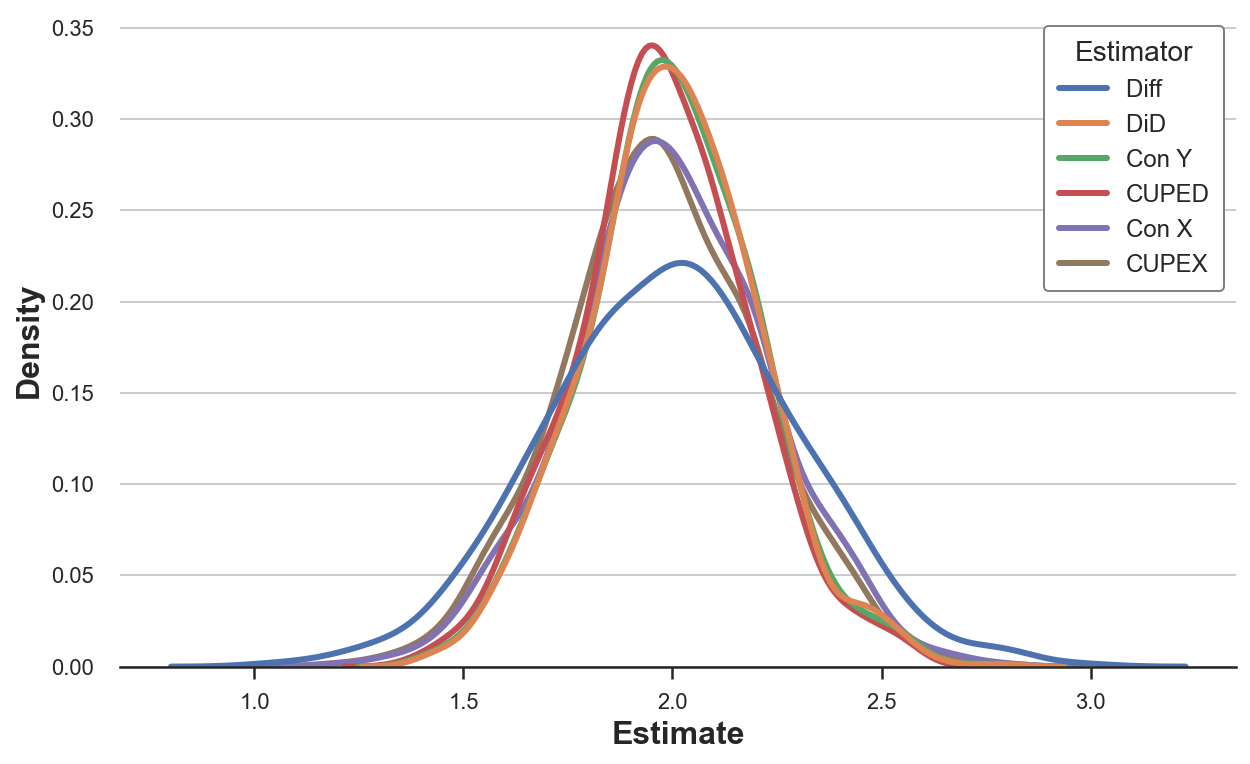

In [22]:
sns.kdeplot(data=results, x="Estimate", hue="Estimator");

Are the means different?

In [23]:
results.groupby('Estimator')[['Estimate']].mean()

,Estimate
Estimator,
CUPED,1.979737
CUPEX,1.975514
Con X,1.996559
Con Y,2.000648
DiD,2.001238
Diff,1.998847


All estimators seem **unbiased**.

What about the standard errors?

In [24]:
results.groupby('Estimator')[['Estimate']].std()

,Estimate
Estimator,
CUPED,0.206764
CUPEX,0.236497
Con X,0.236456
Con Y,0.207183
DiD,0.205980
Diff,0.297775


**Notes**

1. All estimators seem unbiased
2. All estimators seem to have the same variance, a part from the simple difference
3. The DiD estimator has a lower variance than the OLS estimate suggested 

## Conclusion

CONCLUSION

### References

[1] A. Deng, Y. Xu, R. Kohavi, T. Walker, [Improving the Sensitivity of Online Controlled Experiments by Utilizing Pre-Experiment Data](https://dl.acm.org/doi/abs/10.1145/2433396.2433413) (2013), *WSDM*.

[2] H. Xir, J. Aurisset, [Improving the sensitivity of online controlled experiments: Case studies at Netflix](https://dl.acm.org/doi/abs/10.1145/2939672.2939733) (2013), *ACM SIGKDD*.

[3] Y. Guo, D. Coey, M. Konutgan, W. Li, C. Schoener, M. Goldman, [Machine Learning for Variance Reduction in Online Experiments](https://arxiv.org/abs/2106.07263) 

[1] A. Belloni, D. Chen, V. Chernozhukov, C. Hansen, [Sparse Models and Methods for Optimal Instruments With an Application to Eminent Domain](https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA9626) (2012), *Econometrica*.

[2] A. Belloni, V. Chernozhukov, C. Hansen, [Inference on treatment effects after selection among high-dimensional controls](https://academic.oup.com/restud/article-abstract/81/2/608/1523757) (2014), *The Review of Economic Studies*.

[3] V. Chernozhukov, D. Chetverikov, M. Demirer, E. Duflo, C. Hansen, W. Newey, J. Robins, [Double/debiased machine learning for treatment and structural parameters](https://academic.oup.com/ectj/article/21/1/C1/5056401) (2018), *The Econometrics Journal*.

[4] P. Hünermund, B. Louw, I. Caspi, [Double Machine Learning and Automated Confounder Selection - A Cautionary Tale](https://arxiv.org/abs/2108.11294) (2022), *working paper*.

### Related Articles

- [Double Debiased Machine Learning (part 1)](https://towardsdatascience.com/eb767a59975b)
- [Double Debiased Machine Learning (part 2)](https://towardsdatascience.com/bf990720a0b2)
- [Understanding Omitted Variable Bias](https://towardsdatascience.com/344ac1477699)
- [Understanding The Frisch-Waugh-Lovell Theorem](https://towardsdatascience.com/59f801eb3299)
- [DAGs and Control Variables](https://towardsdatascience.com/b63dc69e3d8c)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/cuped.ipynb